# Milestone 2
This notebook aims to delve into and elucidate the pertinent aspects of our datasets, pre-process them in advance, and conduct a preliminary analysis. The initial part encompasses loading the data and incorporates various general preprocessing techniques. The subsequent part encapsulate the preliminary analyses conducted, providing insights into the viability and soundness of our chosen idea.

---
## Contents of notebook:
- [Part 1: Getting Familiar with the Data](#Part-1:-Getting-Familiar-with-the-Data)
    - [Loading the Data](#Loading-the-Data)
    - [Merging the Data](#Merging-the-Data)
---

## Part 1: Getting Familiar with the Data

In [295]:
import pandas as pd
from datetime import datetime as dt
import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import ast
import matplotlib.dates as mdates
import random

### Loading the Data

In [296]:
# Dataset Path
movies_path = 'data/MovieSummaries/movie.metadata.tsv'

# Column Names
movies_names = [
    "wikipedia_movie_ID",
    "freebase_movie_ID",
    "movie_name",
    "movie_release_date",
    "movie_box_office_revenue",
    "movie_runtime",
    "movie_languages",
    "movie_countries",
    "movie_genres",
]

#Year for the analysis
first_year = 1992
last_year = 2012


# Dataframe
movies_df = pd.read_csv(movies_path, sep = "\t", header = None, names = movies_names)

# Dataframe Cleaning 
movies_df["movie_release_date"] = pd.to_datetime(movies_df["movie_release_date"], errors = "coerce")
movies_df = movies_df[movies_df["movie_release_date"].dt.year.between(first_year, last_year)]

# I think this removes too much potential candidates from the pool, as we get the revenues later on anyways (which is where we should actually remove the NA values I think)
# movies_df = movies_df[movies_df["movie_box_office_revenue"].notna()]


In [297]:
# This function transforms the data in the given input (assumed to be a string containing a dictionary like object) into a list of the values contained in the dictionary like object
def dictionary_string_to_list(input):
    res = []
    for value in (ast.literal_eval(input)).values():
        res += [value]
    return res

# We appply the above function iteratively to the genres, countries and languages columns
movies_df["movie_genres"] = movies_df["movie_genres"].apply(dictionary_string_to_list)

# We also filter to keep only the films that were shown in the USA
movies_df["movie_countries"] = movies_df["movie_countries"].apply(dictionary_string_to_list)
movies_df = movies_df[movies_df['movie_countries'].apply(lambda list : "United States of America" in list)]

movies_df["movie_languages"] = movies_df["movie_languages"].apply(dictionary_string_to_list)

# I think we should keep those columns
# movies_df = movies_df.drop(columns = ["movie_languages", "movie_countries"])

# But drop these
movies_df = movies_df.drop(columns = ["wikipedia_movie_ID", "freebase_movie_ID"])

display(movies_df)

,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
12,Little city,1997-04-04,NaN,93.0,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,..."
21,New Rose Hotel,1999-10-01,21521.0,92.0,[English Language],[United States of America],"[Thriller, Science Fiction, Future noir, Indie..."
29,Baby Boy,2001-06-27,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]"
...,...,...,...,...,...,...,...
81678,Confessions of a Sexist Pig,1998-03-07,NaN,91.0,[English Language],[United States of America],"[Romantic comedy, Comedy]"
81684,West 47th Street,2001-03-10,NaN,104.0,[English Language],[United States of America],"[Drama, Documentary]"
81725,State and Main,2000-08-26,6944471.0,106.0,"[Italian Language, English Language]","[France, United States of America]","[Parody, Americana, Comedy]"
81726,Guilty as Sin,1993-06-04,22886222.0,107.0,[],[United States of America],"[Thriller, Erotic thriller, Psychological thri..."


In [298]:
# Dataset Path
usBoxOffice_path = "data/boxofficemojo_august_2019.csv"

# Column Names
usBoxOffice_names = [
    "rank",
    "movie_name",
    "studio",
    "domestic_movie_box_office_revenue",
    "year",
]

# Dataframe
usBoxOffice_df = pd.read_csv(usBoxOffice_path, sep = ",", header = 0, names = usBoxOffice_names)

# Dataframe Cleaning
usBoxOffice_df = usBoxOffice_df[usBoxOffice_df["year"].between(first_year, last_year)]
usBoxOffice_df = usBoxOffice_df.drop(columns = ["rank", "studio", "year"])

display(usBoxOffice_df)

,movie_name,domestic_movie_box_office_revenue
2,Avatar,760507625
5,Titanic,659363944
7,Marvel's The Avengers,623357910
10,The Dark Knight,535234033
14,Star Wars: Episode I - The Phantom Menace,474544677
...,...,...
16530,Playback,264
16533,"Pretty Village, Pretty Flame",211
16536,The Objective,95
16537,Dog Eat Dog,80


### Merging the Data
As the Box Office Mojo dataset solely features movie titles without any corresponding identification, we merged it with the CMU Movie Summary Corpus Dataset using the common identifier of movie_name. This merged dataset now incorporates details regarding the U.S. domestic box office revenue, a crucial element for our analytical endeavors.

In [299]:
# Dataframes Merge
movies_df = pd.merge(
    left = movies_df,
    right = usBoxOffice_df,
    how = "left",
    on = ["movie_name"],
)
movies_df = movies_df[movies_df["domestic_movie_box_office_revenue"].notna()]

display(movies_df)

,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,domestic_movie_box_office_revenue
3,New Rose Hotel,1999-10-01,21521.0,92.0,[English Language],[United States of America],"[Thriller, Science Fiction, Future noir, Indie...",21521.0
4,Baby Boy,2001-06-27,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",28734552.0
5,The Great New Wonderful,2006-06-23,172055.0,87.0,[English Language],[United States of America],"[Drama, Ensemble Film, Comedy-drama, Indie]",150142.0
11,The Bridge,2006-09-01,NaN,69.0,[English Language],[United States of America],[Drama],179780.0
12,The Astronaut Farmer,2006-10-15,11130889.0,104.0,"[English Language, Spanish Language]",[United States of America],"[Science Fiction, Americana, Drama, Adventure,...",11003643.0
...,...,...,...,...,...,...,...,...
8446,Twister,1996-05-10,494471524.0,113.0,[English Language],[United States of America],"[Action/Adventure, Disaster]",241721524.0
8447,Source Code,2011-03-11,147332697.0,93.0,[English Language],"[France, United States of America]","[Thriller, Science Fiction, Action/Adventure, ...",54712227.0
8448,How to Eat Fried Worms,2006-08-25,13040527.0,98.0,[English Language],[United States of America],"[Family Film, Drama, Comedy, Film adaptation]",13040527.0
8451,State and Main,2000-08-26,6944471.0,106.0,"[Italian Language, English Language]","[France, United States of America]","[Parody, Americana, Comedy]",6944471.0


In [300]:
# We need to define the dummy variables not for each possible list containing genres, but for genres within said lists. This function handles this added layer. 
def define_dummy_variables(df, column):
    series = df[column]
    result = pd.get_dummies(series.apply(pd.Series).stack()).sum()
    return result

Genres_df = define_dummy_variables(movies_df, 'movie_genres')
Countries_df = define_dummy_variables(movies_df, 'movie_countries')
Language_df = define_dummy_variables(movies_df, 'movie_languages')

We notice that, overall, the mean tends to increase throughout the year. The issue currently is that this analysis does not factor in the inflation rate, which means that the data is skewed for older movies. To correct this effect, we add a column to our dataset to include the inflation corrected box offices.
There is no perfect method to account for this inflation rate, as many elements must be considered (prices of the tickets vs the inflation rate namely, types of tickets used and so on). The method selected here is to use the mean inflation rate between the release year X and the year 2012 (since this is the last year of our dataset). In practice, this corresponds to what a dollar in year X would be worth in 2012.


In [301]:
inflation_rates_df = pd.read_csv('data/Inflation rate.csv', index_col='Year', sep=';', decimal=',')

# This function allow us to get the inflation rate for a given year
def get_inflation_rate(year):
    return inflation_rates_df.loc[year]['Factor']

# Multiply the inflation rate for the release year by the box office to compute the inflation corrected value
movies_df['Inflation_corrected_box_office'] = movies_df['movie_release_date'].dt.year.apply(get_inflation_rate) * movies_df['domestic_movie_box_office_revenue']

In [302]:
# Describe the box office revenue corrected for inflation per year
for year in range(first_year, last_year+1):
    # Calculate descriptive statistics for each column
    stats = movies_df[movies_df["movie_release_date"].dt.year == year]["Inflation_corrected_box_office"].describe()
    
    # Print the statistics
    # print(f"{year} Descriptive Statistics:")
    # print(stats)
    # print("\n" + "-"*65 + "\n")

In [303]:

# movies_names = [
#     "wikipedia_movie_ID",
#     "freebase_movie_ID",
#     "movie_name",
#     "movie_release_date",
#     "movie_box_office_revenue",
#     "movie_runtime",
#     "movie_languages",
#     "movie_countries",
#     "movie_genres",
# ]

print(movies_df["movie_release_date"])


3      1999-10-01
4      2001-06-27
5      2006-06-23
11     2006-09-01
12     2006-10-15
          ...    
8446   1996-05-10
8447   2011-03-11
8448   2006-08-25
8451   2000-08-26
8452   1993-06-04
Name: movie_release_date, Length: 4177, dtype: datetime64[ns]


In [304]:
from collections import Counter

In [305]:
# Find most used genres
genre_collection = movies_df.movie_genres.sum()
print(genre_collection)
c = Counter(genre_collection)
common_genres = set([elem[0] for elem in c.most_common(10)])
print(common_genres)

['Thriller', 'Science Fiction', 'Future noir', 'Indie', 'Erotic thriller', 'Fantasy', 'Film adaptation', 'Drama', 'Crime Fiction', 'Drama', 'Coming of age', 'Drama', 'Ensemble Film', 'Comedy-drama', 'Indie', 'Drama', 'Science Fiction', 'Americana', 'Drama', 'Adventure', 'Indie', 'Thriller', 'Horror', 'Supernatural', 'Gothic Film', 'Mystery', 'Suspense', 'Disaster', 'Film adaptation', 'Horror', 'Psychological thriller', 'Supernatural', 'Wuxia', 'Fantasy Adventure', 'Adventure', 'Action/Adventure', 'Period piece', 'Martial Arts Film', 'Fantasy', 'Romance Film', 'Action', 'Chinese Movies', 'Romantic comedy', 'Romance Film', 'Slapstick', 'Comedy', 'Indie', 'Erotic Drama', 'Erotica', 'Erotic thriller', 'Drama', 'Romantic drama', 'Romance Film', 'Indie', 'Crime Fiction', 'Tragedy', 'Horror', 'Supernatural', 'Musical', 'Drama', 'Biography', 'Indie', 'Costume drama', 'Period piece', 'Drama', 'Biopic [feature]', 'Biographical film', 'Crime Fiction', 'Action/Adventure', 'Action', 'Buddy film', '

In [306]:
movies_df = movies_df[movies_df['movie_genres'].apply(lambda x: len(x) > 0)]
movies_df = movies_df.reset_index(drop=True)
# display(movies_df)
# Then we want to choose one genre for each movie
def choose_genre(genres):
    # print(genres)
    if len(genres) == 0:
        return ""
    for genre in genres:
        # print(genre)
        if genre in common_genres:
            return genre
    return genres[0]

drop_idxs = []
# movies_df = movies_df.apply(choose_genre, axis=1)
for i in range(len(movies_df)):
    genre = choose_genre(movies_df.iloc[i]['movie_genres'])
    if genre == "":
        drop_idxs.append(i)
    movies_df.at[i, 'movie_genres'] = genre
movies_df = movies_df.drop(drop_idxs).reset_index(drop=True)
display(movies_df)

movies_df.to_csv("data/MovieSummaries/movie_fixed.csv", index=False)

movies_df = pd.read_csv("data/MovieSummaries/movie_fixed.csv")

,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,domestic_movie_box_office_revenue,Inflation_corrected_box_office
0,New Rose Hotel,1999-10-01,21521.0,92.0,[English Language],[United States of America],Thriller,21521.0,3.012940e+04
1,Baby Boy,2001-06-27,29381649.0,123.0,[English Language],[United States of America],Crime Fiction,28734552.0,3.764226e+07
2,The Great New Wonderful,2006-06-23,172055.0,87.0,[English Language],[United States of America],Drama,150142.0,1.741647e+05
3,The Bridge,2006-09-01,NaN,69.0,[English Language],[United States of America],Drama,179780.0,2.085448e+05
4,The Astronaut Farmer,2006-10-15,11130889.0,104.0,"[English Language, Spanish Language]",[United States of America],Drama,11003643.0,1.276423e+07
...,...,...,...,...,...,...,...,...,...
4171,Twister,1996-05-10,494471524.0,113.0,[English Language],[United States of America],Action/Adventure,241721524.0,3.601651e+08
4172,Source Code,2011-03-11,147332697.0,93.0,[English Language],"[France, United States of America]",Thriller,54712227.0,5.690072e+07
4173,How to Eat Fried Worms,2006-08-25,13040527.0,98.0,[English Language],[United States of America],Drama,13040527.0,1.512701e+07
4174,State and Main,2000-08-26,6944471.0,106.0,"[Italian Language, English Language]","[France, United States of America]",Comedy,6944471.0,9.444481e+06


In [307]:
# First we want to reformat the date so we can sort by month
date = pd.to_datetime(movies_df["movie_release_date"])
movies_df["movie_release_year"] = date.dt.year
movies_df["movie_release_month"] = date.dt.month
movies_df["movie_release_day"] = date.dt.day
movies_df = movies_df.sort_values(by=['movie_release_month', 'movie_release_day']).reset_index(drop=True)

movies_df_copy = movies_df.copy(deep=True)
movies_df_copy['movie_release_time'] = movies_df_copy['movie_release_month'].astype(str) + "-" + movies_df_copy['movie_release_day'].astype(str)
display(movies_df_copy)
movies_df_copy['movie_release_time'] = pd.to_datetime(movies_df_copy['movie_release_time'], format='%m-%d')

,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,domestic_movie_box_office_revenue,Inflation_corrected_box_office,movie_release_year,movie_release_month,movie_release_day,movie_release_time
0,Genghis Blues,1999-01-01,NaN,80.0,['English Language'],['United States of America'],Indie,374550.0,524370.00,1999,1,1,1-1
1,Nobody's Perfect,2004-01-01,NaN,15.0,['English Language'],"['United States of America', 'France']",Short Film,2122.0,2631.28,2004,1,1,1-1
2,Hero,2000-01-01,NaN,15.0,['English Language'],['United States of America'],Short Film,53710019.0,73045625.84,2000,1,1,1-1
3,Hero,2000-01-01,NaN,15.0,['English Language'],['United States of America'],Short Film,19507345.0,26529989.20,2000,1,1,1-1
4,Drowning Mona,2000-01-02,15906764.0,96.0,['English Language'],['United States of America'],Crime Fiction,15506764.0,21089199.04,2000,1,2,1-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4171,Another Day in Paradise,1998-12-30,1036818.0,101.0,['English Language'],['United States of America'],Crime Fiction,1036818.0,1472281.56,1998,12,30,12-30
4172,The Matador,2005-12-30,17297244.0,96.0,"['English Language', 'Spanish Language']","['United States of America', 'Ireland', 'Germa...",Indie,12594698.0,15113637.60,2005,12,30,12-30
4173,Confessions of a Dangerous Mind,2002-12-31,33013805.0,113.0,['English Language'],"['United States of America', 'United Kingdom',...",Crime Fiction,16007718.0,20810033.40,2002,12,31,12-31
4174,Oscar and Lucinda,1997-12-31,1897404.0,132.0,[],"['United States of America', 'Australia', 'Uni...",Romance Film,1897404.0,2732261.76,1997,12,31,12-31


/Users/katherinelu/miniconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Count')

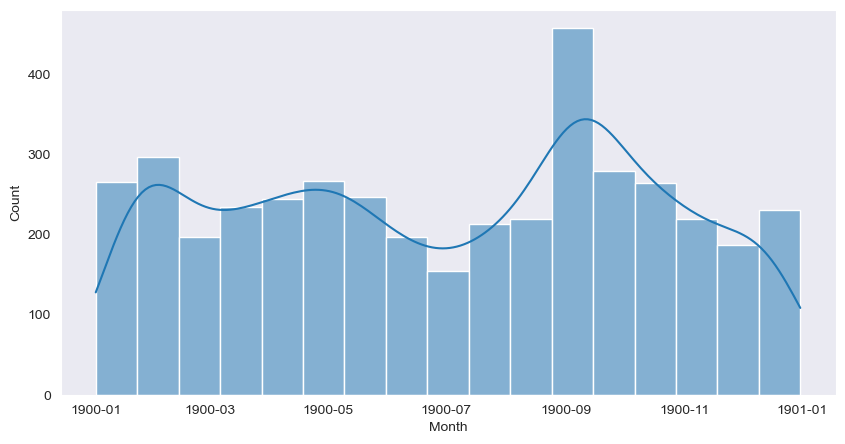

In [308]:
# Plot distribution of days
movies_df_copy['movie_release_day'] = mdates.date2num(movies_df_copy['movie_release_time'])
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

sns.set_style('dark')
sns.histplot(data=movies_df_copy, x='movie_release_time', kde=True)
# ax.set_xlabel('Month')
# ax.set_ylabel('Count')
plt.xlabel("Month")
plt.ylabel("Count")
# plt.xticks(pd.date_range(start=movies_df_copy.index.min(), end=movies_df_copy.index.max(), freq='MS'), rotation=45)
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

# locator = mdates.MonthLocator()
# plt.gca().xaxis.set_major_locator(locator)

# Specify the date format for the x-axis labels
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

In [309]:
sep_limit = 4
revenue_factor = 100

In [310]:
# Propensity matching for movie release date and weather
movies_df_copy_2 = movies_df_copy.copy(deep=True)
movies_df_res = []
sep = 0
while sep < sep_limit:
    i = 0
    drop_idxs = []
    while i < len(movies_df_copy_2) - 1:
        if i in drop_idxs:
            i += 1
            continue
        date_diff = (movies_df_copy_2.iloc[i + 1]['movie_release_time'] - movies_df_copy_2.iloc[i]['movie_release_time']).days
        if date_diff == sep:
            movies_df_res.append(movies_df_copy_2.iloc[i].values)
            movies_df_res.append(movies_df_copy_2.iloc[i + 1].values)
            drop_idxs.extend((i, i + 1))
            i += 2
        else:
            i += 1
    movies_df_copy_2 = movies_df_copy_2.drop(drop_idxs).reset_index(drop=True)
    sep += 1

df_m_matched = pd.DataFrame(movies_df_res, columns=movies_df_copy.columns).sort_values(by=['movie_release_time']).reset_index(drop=True)
# df_m_matched.drop('index', axis=1, inplace=True)

display(df_m_matched)

,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,domestic_movie_box_office_revenue,Inflation_corrected_box_office,movie_release_year,movie_release_month,movie_release_day,movie_release_time
0,Genghis Blues,1999-01-01,NaN,80.0,['English Language'],['United States of America'],Indie,374550.0,524370.00,1999,1,-25567.0,1900-01-01
1,Nobody's Perfect,2004-01-01,NaN,15.0,['English Language'],"['United States of America', 'France']",Short Film,2122.0,2631.28,2004,1,-25567.0,1900-01-01
2,Hero,2000-01-01,NaN,15.0,['English Language'],['United States of America'],Short Film,53710019.0,73045625.84,2000,1,-25567.0,1900-01-01
3,Hero,2000-01-01,NaN,15.0,['English Language'],['United States of America'],Short Film,19507345.0,26529989.20,2000,1,-25567.0,1900-01-01
4,Drowning Mona,2000-01-02,15906764.0,96.0,['English Language'],['United States of America'],Crime Fiction,15506764.0,21089199.04,2000,1,-25566.0,1900-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4153,Another Day in Paradise,1998-12-30,1036818.0,101.0,['English Language'],['United States of America'],Crime Fiction,1036818.0,1472281.56,1998,12,-25204.0,1900-12-30
4154,Lorenzo's Oil,1992-12-30,7286310.0,136.0,"['Italian Language', 'English Language']",['United States of America'],Drama,7286388.0,12095404.08,1992,12,-25204.0,1900-12-30
4155,The Matador,2005-12-30,17297244.0,96.0,"['English Language', 'Spanish Language']","['United States of America', 'Ireland', 'Germa...",Indie,12594698.0,15113637.60,2005,12,-25204.0,1900-12-30
4156,Confessions of a Dangerous Mind,2002-12-31,33013805.0,113.0,['English Language'],"['United States of America', 'United Kingdom',...",Crime Fiction,16007718.0,20810033.40,2002,12,-25203.0,1900-12-31


In [311]:
# TODO: replace with real weather
weather = [random.randint(0, 1) for _ in range(len(df_m_matched))]

# 0 = good, 1 = bad
df_m_matched['weather'] = weather
display(df_m_matched)

,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,domestic_movie_box_office_revenue,Inflation_corrected_box_office,movie_release_year,movie_release_month,movie_release_day,movie_release_time,weather
0,Genghis Blues,1999-01-01,NaN,80.0,['English Language'],['United States of America'],Indie,374550.0,524370.00,1999,1,-25567.0,1900-01-01,0
1,Nobody's Perfect,2004-01-01,NaN,15.0,['English Language'],"['United States of America', 'France']",Short Film,2122.0,2631.28,2004,1,-25567.0,1900-01-01,0
2,Hero,2000-01-01,NaN,15.0,['English Language'],['United States of America'],Short Film,53710019.0,73045625.84,2000,1,-25567.0,1900-01-01,0
3,Hero,2000-01-01,NaN,15.0,['English Language'],['United States of America'],Short Film,19507345.0,26529989.20,2000,1,-25567.0,1900-01-01,0
4,Drowning Mona,2000-01-02,15906764.0,96.0,['English Language'],['United States of America'],Crime Fiction,15506764.0,21089199.04,2000,1,-25566.0,1900-01-02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4153,Another Day in Paradise,1998-12-30,1036818.0,101.0,['English Language'],['United States of America'],Crime Fiction,1036818.0,1472281.56,1998,12,-25204.0,1900-12-30,0
4154,Lorenzo's Oil,1992-12-30,7286310.0,136.0,"['Italian Language', 'English Language']",['United States of America'],Drama,7286388.0,12095404.08,1992,12,-25204.0,1900-12-30,0
4155,The Matador,2005-12-30,17297244.0,96.0,"['English Language', 'Spanish Language']","['United States of America', 'Ireland', 'Germa...",Indie,12594698.0,15113637.60,2005,12,-25204.0,1900-12-30,1
4156,Confessions of a Dangerous Mind,2002-12-31,33013805.0,113.0,['English Language'],"['United States of America', 'United Kingdom',...",Crime Fiction,16007718.0,20810033.40,2002,12,-25203.0,1900-12-31,0


Text(0, 0.5, 'Weather')

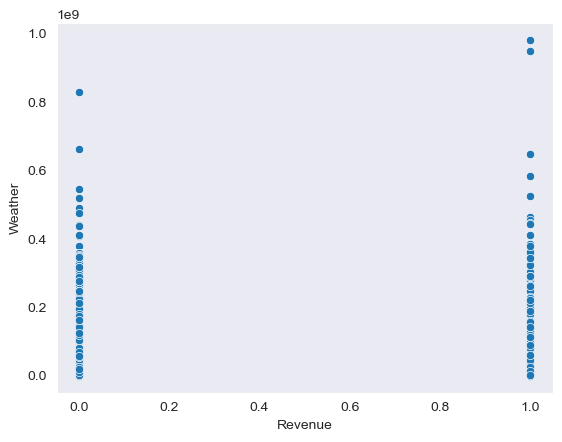

In [312]:
plt.clf()
sns.set_style('dark')
# g = sns.FacetGrid(df_m_matched, row="weather", aspect=6, height=6)
# g.map_dataframe(sns.kdeplot, x="Inflation_corrected_box_office")
sns.scatterplot(data=df_m_matched, x='weather', y='Inflation_corrected_box_office')
plt.xlabel('Revenue')
plt.ylabel('Weather')

In [313]:
movies_df_copy_3 = movies_df_copy.copy(deep=True).sort_values(by=['movie_release_month', 'movie_release_day', 'Inflation_corrected_box_office']).reset_index(drop=True)
display(movies_df_copy_3)

,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,domestic_movie_box_office_revenue,Inflation_corrected_box_office,movie_release_year,movie_release_month,movie_release_day,movie_release_time
0,Nobody's Perfect,2004-01-01,NaN,15.0,['English Language'],"['United States of America', 'France']",Short Film,2122.0,2631.28,2004,1,-25567.0,1900-01-01
1,Genghis Blues,1999-01-01,NaN,80.0,['English Language'],['United States of America'],Indie,374550.0,524370.00,1999,1,-25567.0,1900-01-01
2,Hero,2000-01-01,NaN,15.0,['English Language'],['United States of America'],Short Film,19507345.0,26529989.20,2000,1,-25567.0,1900-01-01
3,Hero,2000-01-01,NaN,15.0,['English Language'],['United States of America'],Short Film,53710019.0,73045625.84,2000,1,-25567.0,1900-01-01
4,Drowning Mona,2000-01-02,15906764.0,96.0,['English Language'],['United States of America'],Crime Fiction,15506764.0,21089199.04,2000,1,-25566.0,1900-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4171,Lorenzo's Oil,1992-12-30,7286310.0,136.0,"['Italian Language', 'English Language']",['United States of America'],Drama,7286388.0,12095404.08,1992,12,-25204.0,1900-12-30
4172,The Matador,2005-12-30,17297244.0,96.0,"['English Language', 'Spanish Language']","['United States of America', 'Ireland', 'Germa...",Indie,12594698.0,15113637.60,2005,12,-25204.0,1900-12-30
4173,Oscar and Lucinda,1997-12-31,1897404.0,132.0,[],"['United States of America', 'Australia', 'Uni...",Romance Film,1897404.0,2732261.76,1997,12,-25203.0,1900-12-31
4174,The Boxer,1997-12-31,16534578.0,114.0,['English Language'],"['United States of America', 'Ireland', 'Unite...",Drama,5980578.0,8612032.32,1997,12,-25203.0,1900-12-31


In [314]:
# Propensity matching for movie release date and revenue
movies_df_res = []
sep = 0
while sep < sep_limit:
    i = 0
    drop_idxs = []
    while i < len(movies_df_copy_3) - 1:
        if i in drop_idxs:
            i += 1
            continue
        date_diff = (movies_df_copy_3.iloc[i + 1]['movie_release_time'] - movies_df_copy_3.iloc[i]['movie_release_time']).days
        revenue_diff = movies_df_copy_3.iloc[i + 1]['Inflation_corrected_box_office'] / movies_df_copy_3.iloc[i]['Inflation_corrected_box_office']
        if date_diff == sep and ((revenue_diff < revenue_factor and revenue_diff > (1 / revenue_factor))):
            movies_df_res.append(movies_df_copy_3.iloc[i].values)
            movies_df_res.append(movies_df_copy_3.iloc[i + 1].values)
            drop_idxs.extend((i, i + 1))
            i += 2
        else:
            i += 1
    movies_df_copy_3 = movies_df_copy_3.drop(drop_idxs).reset_index(drop=True)
    sep += 1

df_mg_matched = pd.DataFrame(movies_df_res, columns=movies_df_copy.columns).sort_values(by=['movie_release_time']).reset_index(drop=True)
# df_mg_matched.drop('index', axis=1, inplace=True)

display(df_mg_matched)

,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,domestic_movie_box_office_revenue,Inflation_corrected_box_office,movie_release_year,movie_release_month,movie_release_day,movie_release_time
0,Genghis Blues,1999-01-01,NaN,80.0,['English Language'],['United States of America'],Indie,374550.0,524370.00,1999,1,-25567.0,1900-01-01
1,Nobody's Perfect,2004-01-01,NaN,15.0,['English Language'],"['United States of America', 'France']",Short Film,2122.0,2631.28,2004,1,-25567.0,1900-01-01
2,Hero,2000-01-01,NaN,15.0,['English Language'],['United States of America'],Short Film,53710019.0,73045625.84,2000,1,-25567.0,1900-01-01
3,Hero,2000-01-01,NaN,15.0,['English Language'],['United States of America'],Short Film,19507345.0,26529989.20,2000,1,-25567.0,1900-01-01
4,Drowning Mona,2000-01-02,15906764.0,96.0,['English Language'],['United States of America'],Crime Fiction,15506764.0,21089199.04,2000,1,-25566.0,1900-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4105,The Matador,2005-12-30,17297244.0,96.0,"['English Language', 'Spanish Language']","['United States of America', 'Ireland', 'Germa...",Indie,12594698.0,15113637.60,2005,12,-25204.0,1900-12-30
4106,Another Day in Paradise,1998-12-30,1036818.0,101.0,['English Language'],['United States of America'],Crime Fiction,1036818.0,1472281.56,1998,12,-25204.0,1900-12-30
4107,Lorenzo's Oil,1992-12-30,7286310.0,136.0,"['Italian Language', 'English Language']",['United States of America'],Drama,7286388.0,12095404.08,1992,12,-25204.0,1900-12-30
4108,Oscar and Lucinda,1997-12-31,1897404.0,132.0,[],"['United States of America', 'Australia', 'Uni...",Romance Film,1897404.0,2732261.76,1997,12,-25203.0,1900-12-31


Text(0, 0.5, 'Weather')

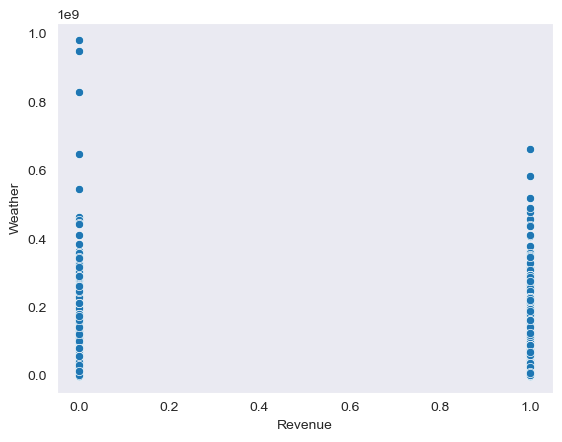

In [315]:
df_mg_matched['weather'] = [random.randint(0, 1) for _ in range(len(df_mg_matched))]
plt.clf()
sns.set_style('dark')
# g = sns.FacetGrid(df_mg_matched, row="weather", aspect=6, height=6)
# g.map_dataframe(sns.kdeplot, x="Inflation_corrected_box_office")
sns.scatterplot(data=df_mg_matched, x='weather', y='Inflation_corrected_box_office')
plt.xlabel('Revenue')
plt.ylabel('Weather')

In [316]:
plt.clf()
sns.set_style('dark')
# g = sns.FacetGrid(df_mg_matched, row="weather", aspect=6, height=6)
# g.map_dataframe(sns.kdeplot, x="Inflation_corrected_box_office")
sns.scatterplot(data=df_mg_matched, x='weather', y='Inflation_corrected_box_office')
a = 
sns.displot(df_mg_matched, x="flipper_length_mm", kind="kde", bw_adjust=.25)
plt.xlabel('Revenue')
plt.ylabel('Weather')

SyntaxError: invalid syntax (3972533972.py, line 6)

In [ ]:
df_mg_matched.to_csv('data.csv')

In [318]:
pip install plotly.express

Note: you may need to restart the kernel to use updated packages.
